klue/roberta-small 모델 사용

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ln -s /content/drive/MyDrive/ /gdrive

In [3]:
!mkdir data

In [4]:
!cp /gdrive/aicon/aicon_retrailer/train/train.csv data/
!cp /gdrive/aicon/aicon_retrailer/test/test.csv data/
!cp /gdrive/aicon/aicon_retrailer/val/val.csv data/
!cp /gdrive/aicon/aicon_retrailer/sample_submission.csv data/

In [5]:
!pip install transformers datasets

     |████████████████████████████████| 2.8 MB 8.2 MB/s 
     |████████████████████████████████| 264 kB 65.9 MB/s 
     |████████████████████████████████| 895 kB 82.3 MB/s 
     |████████████████████████████████| 3.3 MB 67.0 MB/s 
     |████████████████████████████████| 636 kB 93.2 MB/s 
     |████████████████████████████████| 50 kB 400 kB/s 
     |████████████████████████████████| 119 kB 74.9 MB/s 
     |████████████████████████████████| 243 kB 78.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys
import warnings
import re

import numpy as np
import pandas as pd

import datasets
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

import seaborn as sns

#import optuna
#from ray import tune

warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
train = pd.read_csv("./data/train.csv")
valid = pd.read_csv("./data/val.csv")
test = pd.read_csv("./data/test.csv")

In [8]:
dataset = pd.concat([train, valid], join='inner')

In [9]:
map_dict = {'AS_날짜_요청': 0,'AS_날짜_질문': 1,'AS_방법_요청': 2,'AS_방법_질문': 3,'AS_비용_요청': 4,'AS_비용_질문': 5,
                        'AS_시간_질문': 6,'AS_일반_질문': 7,'결제_방식_질문': 8,'결제_수단_질문': 9,'결제_시기_질문': 10,'결제_영수증_질문': 11,
                        '결제_오류_질문': 12,'결제_일반_질문': 13,'결제_일반_확인': 14,'결제_재결제_질문': 15,'결제_추가_질문': 16,
                        '결제_취소_질문': 17,'결제_할인_질문': 18,'교환|반품|환불_방법_요청': 19,'교환|반품|환불_방법_질문': 20,
                        '교환|반품|환불_방법_확인': 21,'교환|반품|환불_비용_질문': 22,'교환|반품|환불_시간_요청': 23,
                        '교환|반품|환불_시간_질문': 24,'교환|반품|환불_일반_요청': 25,'교환|반품|환불_일반_질문': 26,
                        '교환|반품|환불_일반_확인': 27,'구매_예약_요청': 28,'구매_예약_질문': 29,'구매_제품_요청': 30,'구매_제품_질문': 31,
                        '매장_이용_요청': 32,'매장_이용_질문': 33,'매장_정보_질문': 34,'멤버십_사용_질문': 35,'멤버십_적립_질문': 36,
                        '배송_날짜_요청': 37,'배송_날짜_질문': 38,'배송_날짜_확인': 39,'배송_방법_요청': 40,'배송_방법_질문': 41,
                        '배송_방법_확인': 42,'배송_비용_질문': 43,'배송_오류_질문': 44,'배송_오류_확인': 45,'배송_일반_요청': 46,
                        '배송_일반_질문': 47,'배송_일반_확인': 48,'배송_지역_요청': 49,'배송_지역_질문': 50,'배송_택배사_질문': 51,
                        '부가서비스_날짜_요청': 52,'부가서비스_날짜_질문': 53,'부가서비스_방법_요청': 54,'부가서비스_방법_질문': 55,
                        '부가서비스_비용_요청': 56,'부가서비스_비용_질문': 57,'웹사이트_사용_질문': 58,'웹사이트_오류_질문': 59,
                        '제품_가격_비교': 60,'제품_가격_요청': 61,'제품_가격_질문': 62,'제품_가격_확인': 63,'제품_구성_요청': 64,
                        '제품_구성_질문': 65,'제품_구성_확인': 66,'제품_날짜_질문': 67,'제품_방법_요청': 68,'제품_방법_질문': 69,
                        '제품_방법_확인': 70,'제품_불량_요청': 71,'제품_불량_질문': 72,'제품_불량_확인': 73,'제품_소재_질문': 74,
                        '제품_시용_요청': 75,'제품_시용_질문': 76,'제품_용도_질문': 77,'제품_용도_확인': 78,'제품_원산지_질문': 79,
                        '제품_일반_비교': 80,'제품_일반_요청': 81,'제품_일반_질문': 82,'제품_일반_확인': 83,'제품_입고_요청': 84,
                        '제품_입고_질문': 85,'제품_재고_요청': 86,'제품_재고_질문': 87,'제품_재고_확인': 88,'제품_정보_비교': 89,
                        '제품_정보_요청': 90,'제품_정보_질문': 91,'제품_정보_확인': 92,'제품_추천_비교': 93,'제품_추천_요청': 94,
                        '제품_추천_질문': 95,'제품_추천_확인': 96,'제품_커스텀_요청': 97,'제품_커스텀_질문': 98,'제품_품질_비교': 99,
                        '제품_품질_요청': 100,'제품_품질_질문': 101,'제품_품질_확인': 102,'제품_호환_질문': 103,'제품_호환_확인': 104,
                        '포장_방식_요청': 105,'포장_방식_질문': 106,'포장_비용_질문': 107,'포장_일반_질문': 108,'행사_기간_질문': 109,
                        '행사_기간_확인': 110,'행사_날짜_질문': 111,'행사_유형_질문': 112,'행사_유형_확인': 113,'행사_일반_질문': 114,
                        '행사_일반_확인': 115,'행사_정보_요청': 116,'행사_정보_질문': 117,'minor':200,'major':300}

In [10]:
dict_map = {v : k for k, v in map_dict.items()}

dict_map

{0: 'AS_날짜_요청',
 1: 'AS_날짜_질문',
 2: 'AS_방법_요청',
 3: 'AS_방법_질문',
 4: 'AS_비용_요청',
 5: 'AS_비용_질문',
 6: 'AS_시간_질문',
 7: 'AS_일반_질문',
 8: '결제_방식_질문',
 9: '결제_수단_질문',
 10: '결제_시기_질문',
 11: '결제_영수증_질문',
 12: '결제_오류_질문',
 13: '결제_일반_질문',
 14: '결제_일반_확인',
 15: '결제_재결제_질문',
 16: '결제_추가_질문',
 17: '결제_취소_질문',
 18: '결제_할인_질문',
 19: '교환|반품|환불_방법_요청',
 20: '교환|반품|환불_방법_질문',
 21: '교환|반품|환불_방법_확인',
 22: '교환|반품|환불_비용_질문',
 23: '교환|반품|환불_시간_요청',
 24: '교환|반품|환불_시간_질문',
 25: '교환|반품|환불_일반_요청',
 26: '교환|반품|환불_일반_질문',
 27: '교환|반품|환불_일반_확인',
 28: '구매_예약_요청',
 29: '구매_예약_질문',
 30: '구매_제품_요청',
 31: '구매_제품_질문',
 32: '매장_이용_요청',
 33: '매장_이용_질문',
 34: '매장_정보_질문',
 35: '멤버십_사용_질문',
 36: '멤버십_적립_질문',
 37: '배송_날짜_요청',
 38: '배송_날짜_질문',
 39: '배송_날짜_확인',
 40: '배송_방법_요청',
 41: '배송_방법_질문',
 42: '배송_방법_확인',
 43: '배송_비용_질문',
 44: '배송_오류_질문',
 45: '배송_오류_확인',
 46: '배송_일반_요청',
 47: '배송_일반_질문',
 48: '배송_일반_확인',
 49: '배송_지역_요청',
 50: '배송_지역_질문',
 51: '배송_택배사_질문',
 52: '부가서비스_날짜_요청',
 53: '부가서비스_날짜_질문',
 54: '부가서비스_방법_요청',
 55: '부

In [11]:
def set_values(row, value):
    return value[row]

In [12]:
dataset['label'] = dataset['intent'].apply(set_values, args =(map_dict, ))

In [13]:
dataset.label.value_counts(sort = True)

91     72999
38     54908
69     28061
103    24785
65     18246
       ...  
63        71
9         70
78        70
35        66
42        60
Name: label, Length: 118, dtype: int64

In [14]:
dataset.count()

conv_num    374783
intent      374783
question    374783
answer      374783
label       374783
dtype: int64

In [15]:
dataset.head()

,conv_num,intent,question,answer,label
0,5087,AS_날짜_요청,제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.,"네, 무상 리퍼 남았는지 확인 도와드리겠습니다.",0
1,9373,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?,"네, 휴대폰 내일 받으실 수 있습니다.",0
2,9374,AS_날짜_요청,오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?,"네, 이번주 안으로 받으실 수 있습니다.",0
3,9378,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?,"죄송합니다만, 내일 받아보시는건 어렵습니다.",0
4,9379,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?,"아니요, 내일은 어렵습니다.",0


In [16]:
dataset['intent'].fillna('NAN', inplace=True)
dataset['question'].fillna('NAN', inplace=True)
dataset['answer'].fillna('NAN', inplace=True)

In [17]:
dataset['data'] = dataset['question'] + dataset['answer']
test['data'] = test['question'] + test['answer']

In [18]:
dataset.head()

,conv_num,intent,question,answer,label,data
0,5087,AS_날짜_요청,제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.,"네, 무상 리퍼 남았는지 확인 도와드리겠습니다.",0,"제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.네, 무상 리퍼 남았는지 확인..."
1,9373,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?,"네, 휴대폰 내일 받으실 수 있습니다.",0,"오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?네, 휴대폰 내일 받으실 수 있습니다."
2,9374,AS_날짜_요청,오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?,"네, 이번주 안으로 받으실 수 있습니다.",0,"오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?네, 이번주 안으로 받으실..."
3,9378,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?,"죄송합니다만, 내일 받아보시는건 어렵습니다.",0,"오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?죄송합니다만, 내일 받아보시는건 어..."
4,9379,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?,"아니요, 내일은 어렵습니다.",0,"오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?아니요, 내일은 어렵습니다."


In [19]:
test.head()

,conv_num,question,answer,data
0,9710,노트북 수리 맡기면 바로 받을 수 있나요?,오늘 바로 받으실 수 있어요.,노트북 수리 맡기면 바로 받을 수 있나요?오늘 바로 받으실 수 있어요.
1,9711,노트북 수리 맡기면 오늘 받을 수 있어요?,"네, 오늘 받으실 수 있습니다.","노트북 수리 맡기면 오늘 받을 수 있어요?네, 오늘 받으실 수 있습니다."
2,9728,오늘 노트북 수리 들어가면 내일 찾을 수 있죠?,"네, 내일 찾아가세요.","오늘 노트북 수리 들어가면 내일 찾을 수 있죠?네, 내일 찾아가세요."
3,9737,어제 수리맡긴 노트북 내일 찾을 수 있습니까?,"네, 내일 찾으러 오시면 됩니다.","어제 수리맡긴 노트북 내일 찾을 수 있습니까?네, 내일 찾으러 오시면 됩니다."
4,11050,TV AS 이번주 안에 가능한가요?,"네, 이번주까지 해드리겠습니다.","TV AS 이번주 안에 가능한가요?네, 이번주까지 해드리겠습니다."


In [20]:
dataset=dataset[['data','label']]
test=test[['data']]

In [21]:
dataset.head()

,data,label
0,"제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.네, 무상 리퍼 남았는지 확인...",0
1,"오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?네, 휴대폰 내일 받으실 수 있습니다.",0
2,"오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?네, 이번주 안으로 받으실...",0
3,"오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?죄송합니다만, 내일 받아보시는건 어...",0
4,"오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?아니요, 내일은 어렵습니다.",0


In [22]:
test.head()

,data
0,노트북 수리 맡기면 바로 받을 수 있나요?오늘 바로 받으실 수 있어요.
1,"노트북 수리 맡기면 오늘 받을 수 있어요?네, 오늘 받으실 수 있습니다."
2,"오늘 노트북 수리 들어가면 내일 찾을 수 있죠?네, 내일 찾아가세요."
3,"어제 수리맡긴 노트북 내일 찾을 수 있습니까?네, 내일 찾으러 오시면 됩니다."
4,"TV AS 이번주 안에 가능한가요?네, 이번주까지 해드리겠습니다."


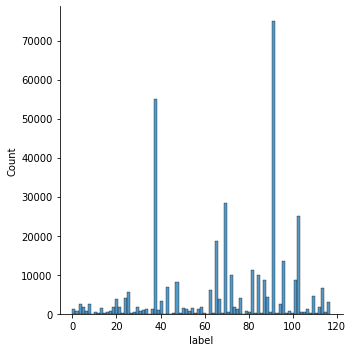

In [23]:
sns.displot(dataset.label)

In [24]:
model_checkpoint = "klue/roberta-small"
RANDOM_SEED = 42

In [25]:
major = [91, 38, 69, 103, 65]

In [26]:
data_list = []
for i in range(118):
  x = dataset['label'] == i
  y = dataset[x]
  data_list.append(y)

In [27]:
sampled_data_list1 = []
sampled_data_list2 = []
for i in range(118):
  if i in major:
    x = data_list[i]
    sampled_data_list1.append(x)
  else:
    x = data_list[i]
    sampled_data_list2.append(x)

In [28]:
def sampled_dataset(sampled_data_list):
  sampled_dataset = pd.DataFrame(index=range(0, 0), columns=['data', 'label'])
  for i in range(len(sampled_data_list)):
    sampled_dataset =  pd.concat([sampled_dataset, sampled_data_list[i]], join='inner')
  return sampled_dataset

In [29]:
sampled_dataset1 = sampled_dataset(sampled_data_list1)

In [30]:
sampled_dataset2 = sampled_dataset(sampled_data_list2)

In [31]:
target = sampled_dataset1['label']
dataset_train1, dataset_val1 = train_test_split(sampled_dataset1,test_size = 0.2, stratify = target, random_state = RANDOM_SEED)

In [32]:
target = sampled_dataset2['label']
dataset_train2, dataset_val2 = train_test_split(sampled_dataset2,test_size = 0.2, stratify = target, random_state = RANDOM_SEED)

In [33]:
ros = RandomOverSampler()
oversampled_data, oversampled_label = ros.fit_resample(dataset_train1, dataset_train1['label'])
dataset_train1 = pd.DataFrame(oversampled_data, columns=dataset_train1.columns)

In [34]:
oversampled_data, oversampled_label = ros.fit_resample(dataset_val1, dataset_val1['label'])
dataset_val1 = pd.DataFrame(oversampled_data, columns=dataset_val1.columns)

In [35]:
dataset_train = pd.concat([dataset_train1, dataset_train2], join='inner')

In [36]:
dataset_val = pd.concat([dataset_val1, dataset_val2], join='inner')

In [37]:
dataset_train.label.value_counts(sort = True)

65     58399
91     58399
103    58399
38     58399
69     58399
       ...  
63        57
9         56
78        56
35        53
42        48
Name: label, Length: 118, dtype: int64

In [38]:
dataset_val.label.value_counts(sort = True)

65     14600
91     14600
103    14600
38     14600
69     14600
       ...  
63        14
45        14
78        14
35        13
42        12
Name: label, Length: 118, dtype: int64

In [39]:
dataset_train.count()

data     432622
label    432622
dtype: int64

In [40]:
dataset_val.count()

data     108157
label    108157
dtype: int64

In [41]:
dataset_train['label'] = dataset_train['label'].apply(lambda x: 200 if x not in major else x)

In [42]:
dataset_val['label'] = dataset_val['label'].apply(lambda x: 200 if x not in major else x)

In [43]:
dataset_train.label.value_counts(sort = True)

200    140627
103     58399
91      58399
69      58399
65      58399
38      58399
Name: label, dtype: int64

In [44]:
dataset_val.label.value_counts(sort = True)

200    35157
103    14600
38     14600
91     14600
69     14600
65     14600
Name: label, dtype: int64

In [45]:
match = {0:200, 1:91, 2:38, 3:69, 4:103, 5:65}

In [46]:
for k, v in match.items():
  dataset_train['label'] = dataset_train['label'].apply(lambda x: k if x == v else x)

In [47]:
for k, v in match.items():
  dataset_val['label'] = dataset_val['label'].apply(lambda x: k if x == v else x)

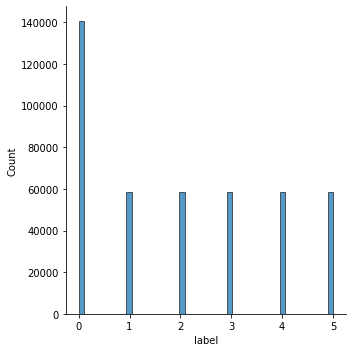

In [48]:
sns.displot(dataset_train.label)

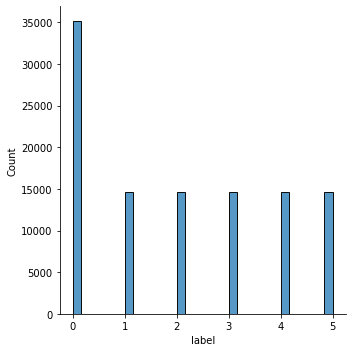

In [49]:
sns.displot(dataset_val.label)

In [50]:
dataset_train.label.value_counts(sort = True)

0    140627
5     58399
4     58399
3     58399
2     58399
1     58399
Name: label, dtype: int64

In [51]:
dataset_val.label.value_counts(sort = True)

0    35157
5    14600
4    14600
3    14600
2    14600
1    14600
Name: label, dtype: int64

In [52]:
dataset_train.count()

data     432622
label    432622
dtype: int64

In [53]:
dataset_val.count()

data     108157
label    108157
dtype: int64

In [54]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

Downloading:   0%|          | 0.00/337 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/545 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [55]:
def tokenized_dataset(dataset, tokenizer):
  tokenized_sentences = tokenizer(
      list(dataset['data']),
      return_tensors="pt",
      padding=True,
      truncation=True
      )
  return tokenized_sentences

In [56]:
# Dataset 구성.
class ROBERTA_Dataset(Dataset):
    def __init__(self, tokenized_dataset, labels):
        self.tokenized_dataset = tokenized_dataset
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.tokenized_dataset.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
    def get_classes(self):
        return self.labels

In [57]:
submission = pd.read_csv('./data/sample_submission.csv')

In [58]:
submission.head()

,conv_num,intent
0,9710,카테고리_채우기
1,9711,카테고리_채우기
2,9728,카테고리_채우기
3,9737,카테고리_채우기
4,11050,카테고리_채우기


In [59]:
submission['label'] = submission['intent']

In [60]:
submission.head()

,conv_num,intent,label
0,9710,카테고리_채우기,카테고리_채우기
1,9711,카테고리_채우기,카테고리_채우기
2,9728,카테고리_채우기,카테고리_채우기
3,9737,카테고리_채우기,카테고리_채우기
4,11050,카테고리_채우기,카테고리_채우기


In [61]:
submission.loc[submission.label == '카테고리_채우기', 'label'] = 0

In [62]:
submission.head()

,conv_num,intent,label
0,9710,카테고리_채우기,0
1,9711,카테고리_채우기,0
2,9728,카테고리_채우기,0
3,9737,카테고리_채우기,0
4,11050,카테고리_채우기,0


In [63]:
train_label=dataset_train['label'].values
val_label=dataset_val['label'].values
test_label=submission['label'].values

tokenized_train = tokenized_dataset(dataset_train, tokenizer)
tokenized_val = tokenized_dataset(dataset_val, tokenizer)
tokenized_test = tokenized_dataset(test, tokenizer)

data_train = ROBERTA_Dataset(tokenized_train, train_label)
data_val = ROBERTA_Dataset(tokenized_val, val_label)
data_test = ROBERTA_Dataset(tokenized_test, test_label)

In [64]:
import gc
gc.collect()

53

In [65]:
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-small were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifi

In [66]:
metric = load_metric("glue", "mnli")

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

In [67]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [68]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

In [69]:
metric_name = "accuracy"

args = TrainingArguments(
    "/gdrive/aicon/aicon_retrailer/backup",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-05,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    greater_is_better=True,
    seed = 42
)

In [70]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=data_train,
    eval_dataset=data_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

loading configuration file https://huggingface.co/klue/roberta-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/6aa0817a5b48e36ec821c3d9cb8267f2dda41a32b317311688f06c742b6b2a1d.7f009d6b27d54554dce063a5fc8273742e9a198f6f627aada4bc5ea2dbbc0313
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_a

In [71]:
trainer.train()

loading configuration file https://huggingface.co/klue/roberta-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/6aa0817a5b48e36ec821c3d9cb8267f2dda41a32b317311688f06c742b6b2a1d.7f009d6b27d54554dce063a5fc8273742e9a198f6f627aada4bc5ea2dbbc0313
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_a

Epoch,Training Loss,Validation Loss,Accuracy
1,0.506700,0.626299,0.794521
2,0.405900,0.743099,0.793005


***** Running Evaluation *****
  Num examples = 108157
  Batch size = 8
Saving model checkpoint to /gdrive/aicon/aicon_retrailer/backup/checkpoint-54078
Configuration saved in /gdrive/aicon/aicon_retrailer/backup/checkpoint-54078/config.json
Model weights saved in /gdrive/aicon/aicon_retrailer/backup/checkpoint-54078/pytorch_model.bin
tokenizer config file saved in /gdrive/aicon/aicon_retrailer/backup/checkpoint-54078/tokenizer_config.json
Special tokens file saved in /gdrive/aicon/aicon_retrailer/backup/checkpoint-54078/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 108157
  Batch size = 8
Saving model checkpoint to /gdrive/aicon/aicon_retrailer/backup/checkpoint-108156
Configuration saved in /gdrive/aicon/aicon_retrailer/backup/checkpoint-108156/config.json
Model weights saved in /gdrive/aicon/aicon_retrailer/backup/checkpoint-108156/pytorch_model.bin
tokenizer config file saved in /gdrive/aicon/aicon_retrailer/backup/checkpoint-108156/tokenizer_config.json
S

TrainOutput(global_step=108156, training_loss=0.49998029256485116, metrics={'train_runtime': 26715.6514, 'train_samples_per_second': 32.387, 'train_steps_per_second': 4.048, 'total_flos': 5.753627554938955e+16, 'train_loss': 0.49998029256485116, 'epoch': 2.0})

In [72]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 108157
  Batch size = 8


{'epoch': 2.0,
 'eval_accuracy': 0.7945209279103526,
 'eval_loss': 0.6262990236282349,
 'eval_runtime': 630.4734,
 'eval_samples_per_second': 171.549,
 'eval_steps_per_second': 21.444}

In [73]:
pred = trainer.predict(data_test)
pred = pred[0]
pred

***** Running Prediction *****
  Num examples = 40730
  Batch size = 8


array([[ 6.507785  ,  0.12208355, -1.1706753 , -1.6931223 , -2.527468  ,
        -1.6236675 ],
       [ 6.4800134 , -0.2813601 , -1.0167793 , -1.9234517 , -2.243822  ,
        -1.3985077 ],
       [ 6.4855356 , -0.08841386, -0.998505  , -2.0811727 , -2.356373  ,
        -1.3749348 ],
       ...,
       [ 6.410573  , -0.5696846 , -1.2728211 , -1.9380187 , -2.2081366 ,
        -0.87695056],
       [ 6.4826813 , -0.18786171, -0.9897212 , -2.0990748 , -2.3471196 ,
        -1.3071555 ],
       [ 6.476905  , -0.30870458, -1.1954362 , -1.9414114 , -2.129858  ,
        -1.3249645 ]], dtype=float32)

In [74]:
np.save("/gdrive/aicon/aicon_retrailer/npy/pred_classifier1_2.npy", pred)

In [75]:
pred = np.argmax(pred,1)
submission['label'] = pred

In [76]:
for k, v in match.items():
  submission['label'] = submission['label'].apply(lambda x: v if x == k else x)

In [77]:
submission.label.value_counts(sort = True)

200    16634
38      7190
91      6251
69      3966
103     3771
65      2918
Name: label, dtype: int64

In [78]:
submission['intent'] = submission['label'].apply(set_values, args =(dict_map, ))
submission.to_csv("/gdrive/aicon/aicon_retrailer/result/klue_roberta_small_trainer_classifier1_2_0.csv",index=False)

In [79]:
submission =submission.drop('label', axis=1)
submission.head()

,conv_num,intent
0,9710,minor
1,9711,minor
2,9728,minor
3,9737,minor
4,11050,minor


In [80]:
submission.to_csv("/gdrive/aicon/aicon_retrailer/result/klue_roberta_small_trainer_classifier1_2_1.csv",index=False)

참고문헌  
transformers 공식문서 How to fine-tune a model on text classification
https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb  

